In [2]:
!pip install torch
!pip install torchmetrics
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 51.2 MB/s eta 0:00:00


In [3]:
# Handling Model
import copy
import os

import torch

from torchmetrics import Dice

import matplotlib.pyplot as plt

from dataset import PolypsSegmentationDataset

Dataset

In [4]:
# define path to images
image_path = './Kvasir-SEG'
size = 256
# get dataset, need resize to be divisible by 16 for all 4 max pools, to keep 
dataset = PolypsSegmentationDataset(image_path,size)
augmented_dataset = PolypsSegmentationDataset(image_path,size,True)

100%|██████████| 1000/1000 [00:00<00:00, 569259.50it/s]


In [5]:
def splitDataset(augmented_dataset):
    # Split dataset into a test and train datasets
    subsets = []

    # Get a size of fifth of dataset
    test_split = (int)(len(augmented_dataset) / 5)

    # Split fifth of dataset into test dataset
    remaining = len(augmented_dataset) - test_split
    test_dataset, remaining_dataset  = torch.utils.data.random_split(augmented_dataset, [test_split, remaining])

    # Get size of 1/10 of dataset
    split = (int)(len(augmented_dataset) / 10)

    # Split the remaining into 1/10 of original dataset, for training set
    while remaining >= 77:
        remaining = len(remaining_dataset) - split
        split_dataset, remaining_dataset  = torch.utils.data.random_split(remaining_dataset, [split, remaining])
        subsets.append(split_dataset)
    # If there is still some data left, add it to the last subset
    if(remaining > 0):
        subsets.append(remaining_dataset)
        
    return subsets, test_dataset

Training Method

In [6]:
# Define the training function
def train_fn(model, loss_fn, dataloader, optimizer, device = 'cpu'):
    
    model.train()

    avg_loss = 0
    for i, (X, y) in enumerate(dataloader):
        # Get data
        X_train, y_train = X.to(device), y.to(device)  
        # Get Output
        output = model(X_train).to(device)
        # Compute loss
        loss = loss_fn(output, y_train)
        avg_loss += loss.item()
        # Optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return avg_loss / len(dataloader)
    
        

Test Method

In [7]:
def test_fn(model, loss_fn, dice, dataloader, device = 'cpu'):
    model.eval()
    test_loss = 0
    test_dice = 0
    with torch.inference_mode():
        for i, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            output = model(X)
            loss = loss_fn(output, y)
            test_loss += loss.item()
            test_dice += dice(torch.where(output > 0.5, 1, 0),torch.where(y > 0.50, 1, 0)).item()

    
    test_loss /= len(dataloader)
    test_dice /= len(dataloader)
    
    return test_loss, test_dice

Save Model Method

In [11]:
def saveModel(model, name):
    # Directory Name
    directory = './models/'
    # Create models folder and checks if it exists
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory {directory} created successfully...")
    # Define path and name
    path = os.path.join(directory, name)
    # Save model
    torch.save(model, path)
    print(f"{name} saved succesfully")

Training

In [12]:
splits = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

BATCH_SIZE = 32

device = 'cuda' if torch.cuda.is_available() else 'cpu'

lr = 0.01
loss_fn = torch.nn.BCELoss()


dice = Dice(average = 'micro', num_classes = 2, threshold = 0.5).to(device)

In [14]:
SPLIT_TEST_DICE = [0,0,0,0,0,0,0,0]
SPLIT_TEST_LOSS = [0,0,0,0,0,0,0,0]

# Number of times to run experiment
iterations = 4

# Threshold loss to stop training model
threshold_loss = 0.3

# Run experiment multiple times
for j in range(iterations):
    # Get test dataset and train splits
    subsets, test_dataset = splitDataset(augmented_dataset)
    for i in range(len(subsets)):
        # Initialize model, optimizer, and learning rate scheduler
        model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet', in_channels=3, out_channels=1, init_features=64, pretrained=False, trust_repo=True).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr)
        lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
        name = f'UNet|Split:{(i+1)/10}|Iter:{j}'
        
        # Create train dataset for split
        train_dataset = torch.utils.data.ConcatDataset(subsets[:i+1])
        
        # Load datasets into dataloaders
        if i == 0: # Error when loading single dataset in concat into loader, so seperate case
            train_dataloader = torch.utils.data.DataLoader(dataset=subsets[i], batch_size=BATCH_SIZE, shuffle =True)
        else:
            train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle =True)
        test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle =False)
        
        # Initialize loss and previous loss
        loss = float("inf")
        best_loss = float("inf")
        # Train model until it reaches threshold loss
        while(loss > threshold_loss):
            # Compute training loss
            loss = train_fn(model, loss_fn, train_dataloader, optimizer, device)
            # Update best loss if new loss is less than it
            if best_loss > loss:
                best_loss = loss
            # Adjust learning rate if new loss is worse than best loss
            else:
                lr_scheduler.step()
        # Check accuracy and loss on test set
        test_loss , test_dice = test_fn(copy.deepcopy(model), loss_fn, dice, test_dataloader, device)
        # Save model
        saveModel(model,name)
        # Save test loss and dice score for plotting later
        SPLIT_TEST_DICE[i] += test_dice
        SPLIT_TEST_LOSS[i] += test_loss
# Take average of experiments
for i in range(len(subsets)):
    SPLIT_TEST_DICE[i] /= iterations
    SPLIT_TEST_LOSS[i] /= iterations
    

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


UNet|Split:0.1|Iter:0 saved succesfully


Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


UNet|Split:0.2|Iter:0 saved succesfully


Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


UNet|Split:0.3|Iter:0 saved succesfully


Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


UNet|Split:0.4|Iter:0 saved succesfully


Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


UNet|Split:0.5|Iter:0 saved succesfully


Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


UNet|Split:0.6|Iter:0 saved succesfully


Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


UNet|Split:0.7|Iter:0 saved succesfully


Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


UNet|Split:0.8|Iter:0 saved succesfully


Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


UNet|Split:0.1|Iter:1 saved succesfully


Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


UNet|Split:0.2|Iter:1 saved succesfully


Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


UNet|Split:0.3|Iter:1 saved succesfully


Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


UNet|Split:0.4|Iter:1 saved succesfully


Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


UNet|Split:0.5|Iter:1 saved succesfully


Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


UNet|Split:0.6|Iter:1 saved succesfully


Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


UNet|Split:0.7|Iter:1 saved succesfully


Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


UNet|Split:0.8|Iter:1 saved succesfully


Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


UNet|Split:0.1|Iter:2 saved succesfully


Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


UNet|Split:0.2|Iter:2 saved succesfully


Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


UNet|Split:0.3|Iter:2 saved succesfully


Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


UNet|Split:0.4|Iter:2 saved succesfully


Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


UNet|Split:0.5|Iter:2 saved succesfully


Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


UNet|Split:0.6|Iter:2 saved succesfully


Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


UNet|Split:0.7|Iter:2 saved succesfully


Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


UNet|Split:0.8|Iter:2 saved succesfully


Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


KeyboardInterrupt: 

/tmp/ipykernel_50/2645843080.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_xticklabels(splits)
/tmp/ipykernel_50/2645843080.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(splits)


[Text(-1.0, 0, '0.1'),
 Text(0.0, 0, '0.2'),
 Text(1.0, 0, '0.3'),
 Text(2.0, 0, '0.4'),
 Text(3.0, 0, '0.5'),
 Text(4.0, 0, '0.6'),
 Text(5.0, 0, '0.7'),
 Text(6.0, 0, '0.8'),
 Text(7.0, 0, '0.9'),
 Text(8.0, 0, ''),
 Text(9.0, 0, '')]

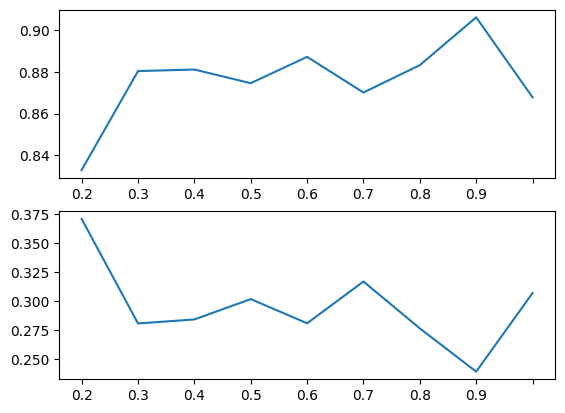

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot test loss and dice
splits = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,]

fig, ax = plt.subplots(2,1)
plt.figure()
ax[0].plot(SPLIT_TEST_DICE, label = "Split Dice Score")
ax[0].title("Split Dice Score")
ax[0].xlabel("Split")
ax[0].ylabel("Dice Score")
ax[0].set_xticklabels(splits)
ax[1].plot(SPLIT_TEST_LOSS, label = "Split Loss")
ax[1].title("Split Loss")
ax[1].xlabel("Split")
ax[1].ylabel("Loss")
ax[1].set_xticklabels(splits)

In [11]:
# Test Models
for split in splits:

    model = torch.load(f"./models/UNet|Split:{split}")
    # Get loss and dice score of the test data
    test_loss , test_dice = test_fn(copy.deepcopy(model), loss_fn, dice, test_dataloader, device)
    # Save test loss and dice score for plotting later
    SPLIT_TEST_LOSS.append(test_loss)
    SPLIT_TEST_DICE.append(test_dice)

ModuleNotFoundError: No module named 'unet'